# GA Capstone
## Classification Modeling

The goal here is to create a binary classification model that will classify text as being Shakespearian or not. The model was fed all of Shakespeare's works, split into sentences, as the positive class. The negative class included poetic works by other Elizabethan-era authors, other 17th century poets, other sonnetteers, and random text generated by GPT2. I didn't realize Shakespeare's work was so vast! The length of Shakespeare's works exceeded that of all other sources combined by almost double!

Much of the below is adapted from the [Hugging Face Text Classification Tutorial](https://huggingface.co/docs/transformers/tasks/sequence_classification) and the notebook linked therein.

### Imports and Preliminaries

In [1]:
# IMPORTS
# Datasets for dataset formatting
from datasets import Dataset, DatasetDict

# tokenizer and collator
from transformers import AutoTokenizer, DataCollatorWithPadding

# model and optimizer
from transformers import TFAutoModelForSequenceClassification, create_optimizer

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# support
import numpy as np
import os
import re
import random
import json

# custom utilities
from utilities.utilities import load_config, get_dataset_from_config
from utilities.utilities import train_test_val_split, split_text_and_labels
from utilities.utilities import classify_from

In [2]:
# load config from json
CONFIG_FILE = 'config.json'

config_vars = load_config(CONFIG_FILE)
config_vars

{'RANDOM_SEED': 1,
 'MODEL_DIR': '../models/',
 'DATA_DIR': '../data/',
 'CAUSAL_N_EPOCHS': 8,
 'CLASS_N_EPOCHS': 2,
 'BATCH_SIZE': 16,
 'CAUSAL_MODEL': 'distilgpt2',
 'CLASS_MODEL': 'distilbert-base-uncased',
 'MODEL_NAME': 'shakespeare',
 'DATA_SHAKESPEARE': ['shakespeare-sonnets.clean.txt', 'shakespeareplays.txt'],
 'DATA_OTHER': ['belloc_hilaire-sonnets_and_verse.clean.txt',
  'blake_william-poems.clean.txt',
  'browning_elizabeth-sonnets_from_the_portuguese.clean.txt',
  'daniel_samuel_and_constable_henry-elizabethan_sonnet_cycles.clean.txt',
  'donne_john-poetry_vol_1.clean.txt',
  'drayton_michael_et_al-elizabethan_sonnet_cycles.clean.txt',
  'farjeon_eleanor-sonnets_and_poems.clean.txt',
  'keats_john-poems_1820.clean.txt',
  'lodge_thomas_and_fletcher_giles-elizabethan_sonnet_cycles.clean.txt',
  'lovell_robert_and_southey_robert-poems.clean.txt',
  'milton_john-poetical_works.clean.txt',
  'seward_anna-sonnets-and-odes.clean.txt',
  'shelley_percy-complete_poetic_works.clean.

In [3]:
# random seed
SEED = config_vars['RANDOM_SEED'] if 'RANDOM_SEED' in config_vars else 1

# pretrained model designator
MODEL_TYPE = config_vars['CLASS_MODEL'] if 'CLASS_MODEL' in config_vars else 'distilbert-base-uncased'

# model batch size
BATCH_SIZE = config_vars['BATCH_SIZE'] if 'BATCH_SIZE' in config_vars else 16

# model num epochs
N_EPOCHS = config_vars['CLASS_N_EPOCHS'] if 'CLASS_N_EPOCHS' in config_vars else 8

# whether to downsample
SAMPLE = config_vars['N_SAMPLES'] if 'N_SAMPLES' in config_vars else 1

In [4]:
# directories, etc.
MODEL_DIR = config_vars['MODEL_DIR'] if 'MODEL_DIR' in config_vars else '../models/'
MODEL_NAME = config_vars['MODEL_NAME'] if 'MODEL_NAME' in config_vars else 'shakespeare'
MODEL_FULL_PATH = os.path.join(MODEL_DIR, f'{MODEL_NAME}.{MODEL_TYPE}.{N_EPOCHS}')

DATA_DIR = config_vars['DATA_DIR'] if 'DATA_DIR' in config_vars else '../data/'

### Data Loading and Preparation

In [5]:
# load data and split into sentences
data = get_dataset_from_config(config_vars, limit=SAMPLE)
len(data[0]), data[0][:2], len(data[1]), data[1][:2]

(36809,
 [('Lift up your hearts in Gumber, laugh the Weald And you my mother the Valley of Arun sing.',
   0),
  ('Here am I homeward from my wandering Here am I homeward and my heart is healed.',
   0)],
 76578,
 [('From fairest creatures we desire increase, That thereby beauty’s rose might never die, But as the riper should by time decease, His tender heir might bear his memory:',
   1),
  ('But thou, contracted to thine own bright eyes, Feed’st thy light’s flame with self-substantial fuel, Making a famine where abundance lies, Thyself thy foe, to thy sweet self too cruel:',
   1)])

In [6]:
# create train-test-val-split
# adding a validation split for the NN model
data_ttvs = train_test_val_split(data, seed=SEED)
data_ttvs['train'][:2], data_ttvs['test'][:2], data_ttvs['val'][:2]

([('With an eye of green in ’t.', 1),
  ('and so would you, For all this spice of your hypocrisy.', 1)],
 [('and our children shall See it plaine Rashe awhile, then nought at all.',
   0),
  ('Pray you, give me my gown—or else keep it in your arms.', 1)],
 [('Even whilst we speak The ministers of justice wait below:', 0),
  ('I myself would have no power;', 1)])

In [7]:
# format into DatasetDict format
train_data = Dataset.from_dict(split_text_and_labels(data_ttvs['train']))
test_data = Dataset.from_dict(split_text_and_labels(data_ttvs['test']))
val_data = Dataset.from_dict(split_text_and_labels(data_ttvs['val']))
dataset = DatasetDict({'train': train_data, 'test': test_data, 'val': val_data})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 100917
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 11337
    })
    val: Dataset({
        features: ['text', 'labels'],
        num_rows: 1133
    })
})

### Tokenization and Prepping Collator

In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_TYPE)

def tokenizer_func(text):
    return tokenizer(text['text'])

In [9]:
tokenized_data = dataset.map(tokenizer_func, batched=True)

  0%|          | 0/101 [00:00<?, ?ba/s]

  0%|          | 0/12 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [10]:
collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')

### Modeling

In [11]:
# instantiate model
if os.path.exists(MODEL_FULL_PATH):
    model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_FULL_PATH)
else:
    model = TFAutoModelForSequenceClassification.from_pretrained(MODEL_TYPE)

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at ../models/shakespeare.distilbert-base-uncased.2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [12]:
# prep train and test sets for model
tf_train_set = model.prepare_tf_dataset(
    tokenized_data['train'],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=collator
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_data['test'],
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=collator
)

tf_val_set = model.prepare_tf_dataset(
    tokenized_data['val'],
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=collator
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [13]:
# set up optimizer
batches_per_epoch = len(tokenized_data['train']) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * N_EPOCHS)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [14]:
# compile and fit model
if not os.path.exists(MODEL_FULL_PATH):
    model.compile(optimizer=optimizer)
    model.fit(tf_train_set, validation_data=tf_val_set, epochs = N_EPOCHS)
    os.makedirs(MODEL_FULL_PATH)
    model.save_pretrained(MODEL_FULL_PATH)

### Evaluate

Evaluate classification model based on standard classification metrics.

               precision    recall  f1-score   support

      Amateur       0.89      0.84      0.87       803
Shakespearean       0.93      0.95      0.94      1697

     accuracy                           0.92      2500
    macro avg       0.91      0.90      0.90      2500
 weighted avg       0.92      0.92      0.92      2500



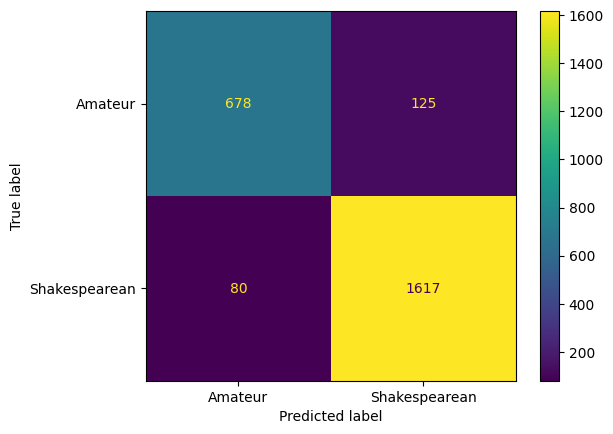

In [15]:
# set to 0 to run full test dataset, otherwise will sample fewer lines
# full set crashed my kernel. Running on an almost-full subset...
NUM_TESTS = 2500

if not NUM_TESTS: NUM_TESTS = len(test_data)

tests = random.sample(list(zip(test_data['text'], test_data['labels'])), NUM_TESTS)
tests = list(zip(*tests))
test_text = list(tests[0])
test_class = list(tests[1])

# This is to correct a very new error I've encountered. Seems to work OK...
tokenizer.pad_token = tokenizer.eos_token = '<PAD>'

# get results of classification
results = classify_from(test_text, model, tokenizer)

# get predictions and true labels
preds = results.c
true = test_class

# print metrics
print(classification_report(true, preds, target_names=['Amateur', 'Shakespearean']))
ConfusionMatrixDisplay(confusion_matrix(true, preds), display_labels=['Amateur', 'Shakespearean']).plot()

### Conclusion

As demonstrated by the metrics, the BERT-based classification model performs superbly. 92% accuracy is better than 67% baseline.